Import relevant libraries:

In [55]:
import pandas as pd
import glob #For combining individual files into one dataframe
from pathlib import Path
import matplotlib.pyplot as plt 
from IPython.display import display #For better display of high dimension dataframes. 

## Functions and settings
### Define functions: 


In [56]:
def plot_voyage_on_coastline(voyage_data, coastline_data, padding=0.05):
    """
    Function to plot a voyage's trajectory on a coastline map.

    Args:
        voyage_data: DataFrame containing voyage data, including latitude, longitude, and timestamps.
        coastline_data: GeoDataFrame containing coastline data in GeoPandas format.
        padding: Float padding around the trajectory for zooming.
    """
    
    # Ensure the data is sorted by timestamp
    voyage_data = voyage_data.sort_values(by="pos_timestamp", ascending=True, inplace=False)

    # Get min/max latitudes and longitudes from the voyage data to define the zoom area
    min_lon, max_lon = voyage_data.longitude.min(), voyage_data.longitude.max()
    min_lat, max_lat = voyage_data.latitude.min(), voyage_data.latitude.max()

    # Add some padding to the zoom area
    xlim = (min_lon - padding, max_lon + padding)
    ylim = (min_lat - padding, max_lat + padding)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the coastline
    coastline_data.plot(ax=ax, color='black', linewidth=0.8, label="Coastline")

    # Plot the vessel trajectory
    ax.plot(voyage_data.longitude, voyage_data.latitude, marker='o', linestyle='-', color='b', label="Voyage Trajectory")

    # Set axis limits for zooming in
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Voyage Trajectory on Coastline Map")

    # Show legend and grid
    ax.legend()
    ax.grid()

    # Show the plot
    plt.show()

In [57]:
def analyze_max_speed_context(df, window_size=30, figsize=(10, 6)):
    """
    Find max speed points and plot trajectory context window.
    
    Args:
        df: DataFrame with 'speed_over_ground', 'longitude', 'latitude' columns
        window_size: Number of samples before/after max speed to include
        figsize: Plot size tuple
    """
    
    # Find max speed rows
    max_speed_sample = df[df['speed_over_ground'] == df['speed_over_ground'].max()]
    max_indices = max_speed_sample.index.tolist()
    
    # Collect surrounding indices
    surrounding_indices = []
    for idx in max_indices:
        start_index = max(0, idx - window_size)
        end_index = min(len(df), idx + window_size + 1)
        surrounding_indices.extend(range(start_index, end_index))
    
    # Remove duplicates and sort
    surrounding_indices = sorted(set(surrounding_indices))
    subset_samples = df.iloc[surrounding_indices]
    
    # Display subset
    print("Max speed context samples:")
    display(subset_samples.head())
    print()
    
    # Plot trajectory
    plt.figure(figsize=figsize)
    plt.plot(subset_samples.longitude, subset_samples.latitude, 
             marker='o', linestyle='-', color='b', label="Trajectory")
    
    # Highlight max speed points
    plt.scatter(max_speed_sample.longitude, max_speed_sample.latitude, 
                color='r', s=100, label="Max Speed Points", zorder=5)
    
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Trajectory Around Max Speed ({df['speed_over_ground'].max():.2f} knots)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [58]:
def analyze_voyage_max_speeds(df, mmsi, speed_col='speed_over_ground', id_col='voyage_id'):
    """
    Analyze max speeds per voyage for a specific MMSI.
    
    Args:
        df: AIS DataFrame with mmsi, voyage_id, speed_over_ground columns
        mmsi: Vessel MMSI to analyze
        speed_col: Column name for speed (default: 'speed_over_ground')
        id_col: Column name for voyage ID (default: 'voyage_id')
    
    Returns:
        dict: {voyage_id: max_speed} mapping
    """

    # Subset for specific vessel
    subset_samples = df[df["mmsi"] == mmsi]
    
    if subset_samples.empty:
        print(f"No data found for MMSI {mmsi}")
        return {}, subset_samples
    
    # Find unique voyages and max speeds
    sample_voyages = subset_samples[id_col].unique()
    max_speeds_per_voyage = subset_samples.groupby(id_col)[speed_col].max().round(2)
    
    # Print results
    print(f'Max speeds for each voyage of MMSI {mmsi}:')
    print('-' * 45)

    for voyage_id, max_speed in max_speeds_per_voyage.items():
        print(f"Voyage ID: {voyage_id}, max speed: {max_speed} knots")
    
    print(f"\nTotal samples (AIS data points) for MMSI {mmsi}: {len(subset_samples)}")
    print(f"Total unique voyages: {len(sample_voyages)}")

    return max_speeds_per_voyage.to_dict(), subset_samples, sample_voyages

In [59]:
def load_data_as_df(dir=None, parent_dir_path="./data/mission-voyage-examples", engine='fastparquet'):
    """
    Load AIS and metadata Parquet files into a DataFrame.
    
    Returns:
        df: DataFrame
    """

    folder = Path(parent_dir_path)
    
    if dir:
        files = list(folder.glob(dir))
        if not files:
            print(f"No files found: {dir}")
            return pd.DataFrame()
        
        print(f"Files: {files}")
        df = pd.concat([pd.read_parquet(f, engine=engine) for f in files], ignore_index=True)
        print(f"Loaded {len(df):,} rows from \"{parent_dir_path}/{dir}\"")
        return df

### Define dataframe settings


In [60]:
#Set pandas options to display all columns without collapsing
pd.set_option('display.max_columns', None)  #No column limit
pd.set_option('display.width', None)  #Auto-width adjustment
pd.set_option('display.max_rows', None)  #You can adjust the number of rows displayed

## Load datasets
### Coastline dataset: 



Source: https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/

<Axes: >

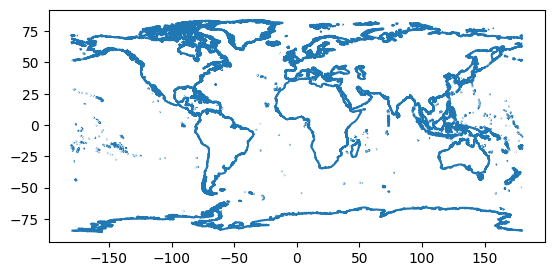

In [61]:
#Load coastline data from Natural Earth 
import geopandas as gpd
coastline = gpd.read_file(Path("./data/ne_10m_coastline/ne_10m_coastline.shp"))
coastline.plot()

### AIS data from Awake
The AIS dataset contains samples from multiple different ships, with each ship identified by the mmsi column. 

When the data is sorted chronologically it is a timeseries of positions for the corresponding ship. 
This timeseries is furthermore, through Awakes processing and not inherently in AIS, annotated with a voyage_id. 
This voyage_id indicates a voyage to/from the port of interest (In this dataset: Valencia) detected by Awakes processing systems. 

A voyage may also entail a shifting inside the port, where the vessel was berthed in port, moved to a different berth inside the port and the moored up again. 
The corresponding meta dataset contains information on the individual voyage_ids, such as departure location & time, arrival location & time and duration.  

Below code block loads the zip files received from Awake, by first defining file name format and then aggregating individual dates/files into one combined dataframe. Done for both Arrivals and Departures and meta data:

In [62]:
#Create Dataframes of the file types
arrivals_ais = load_data_as_df("ESVLC-arrivals-voyage-ais-data-*.parquet.gzip")
arrivals_meta = load_data_as_df("ESVLC-arrivals-voyage-metadata-*.parquet.gzip")
departures_ais = load_data_as_df("ESVLC-departures-voyage-ais-data-*.parquet.gzip")
departures_meta = load_data_as_df("ESVLC-departures-voyage-metadata-*.parquet.gzip")

Files: [PosixPath('data/mission-voyage-examples/ESVLC-arrivals-voyage-ais-data-2024-01-01--2024-02-01.parquet.gzip'), PosixPath('data/mission-voyage-examples/ESVLC-arrivals-voyage-ais-data-2024-02-01--2024-03-01.parquet.gzip'), PosixPath('data/mission-voyage-examples/ESVLC-arrivals-voyage-ais-data-2024-03-01--2024-04-01.parquet.gzip'), PosixPath('data/mission-voyage-examples/ESVLC-arrivals-voyage-ais-data-2024-04-01--2024-05-01.parquet.gzip'), PosixPath('data/mission-voyage-examples/ESVLC-arrivals-voyage-ais-data-2024-05-01--2024-06-01.parquet.gzip'), PosixPath('data/mission-voyage-examples/ESVLC-arrivals-voyage-ais-data-2024-06-01--2024-07-01.parquet.gzip'), PosixPath('data/mission-voyage-examples/ESVLC-arrivals-voyage-ais-data-2024-07-01--2024-08-01.parquet.gzip'), PosixPath('data/mission-voyage-examples/ESVLC-arrivals-voyage-ais-data-2024-08-01--2024-09-01.parquet.gzip'), PosixPath('data/mission-voyage-examples/ESVLC-arrivals-voyage-ais-data-2024-09-01--2024-10-01.parquet.gzip'), Po

In [63]:
print(f"Arrivals AIS data set shape: {arrivals_ais.shape}")
print(f"Arrivals META data set shaoe: {arrivals_meta.shape}")

Arrivals AIS data set shape: (3311442, 50)
Arrivals META data set shaoe: (43352, 17)


In [64]:
print('Snippet of arrivals AIS dataset:')
display(arrivals_ais.head())

print('\nSnippet of arrivals META dataset:')
display(arrivals_meta.head())

Snippet of arrivals AIS dataset:


,voyage_id,voyage_status,mmsi,pos_timestamp,navigation_status,position_accuracy,longitude,latitude,course_over_ground,true_heading,timestamp_seconds,raim,rate_of_turn,speed_over_ground,pos_source,call_sign,name,ship_type,ref_point_a,ref_point_b,ref_point_c,ref_point_d,position_device,eta,draught,destination,meta_timestamp,imo,meta_source,flag,build_year,length,width,capacity_dwt,manager,owner,builder,class_society,capacity_gt,capacity_teu,capacity_liquid_gas,capacity_passenger,capacity_liquid_oil,commercial_size_class,vessel_type_details,draught_max,draught_min,capacity_nt,vid_prefix,month
0,00924e48-65ea-4ec5-85bc-d97828d10df4,PENDING_DEPARTURE,224185730,2024-01-01 05:11:09,UNDEFINED,False,-0.330460,39.426970,360.000000,511,60,False,128.0,0.0,AISHUB,EA9147,SILVIA,0,0,0,0,0,GPS,NaT,0.0,,2023-12-31 23:18:45,0,SPIRE,ES,0,12.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,00,2024-01
1,00924e48-65ea-4ec5-85bc-d97828d10df4,PENDING_DEPARTURE,224185730,2024-01-01 05:29:09,UNDEFINED,False,-0.330560,39.426960,360.000000,511,60,False,128.0,0.1,AISHUB,EA9147,SILVIA,0,0,0,0,0,GPS,NaT,0.0,,2023-12-31 23:18:45,0,SPIRE,ES,0,12.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,00,2024-01
2,00924e48-65ea-4ec5-85bc-d97828d10df4,PENDING_DEPARTURE,224185730,2024-01-01 05:50:10,UNDEFINED,False,-0.330510,39.426940,360.000000,511,60,False,128.0,0.1,AISHUB,EA9147,SILVIA,0,0,0,0,0,GPS,NaT,0.0,,2023-12-31 23:18:45,0,SPIRE,ES,0,12.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,00,2024-01
3,0194e307-841e-4b36-85e6-4eec645c9d0a,STOPPED,636015990,2024-01-01 05:00:22,AT_ANCHOR,True,-0.257450,39.395163,236.899994,241,17,False,0.0,0.0,SPIRE,D5DW6,NIMERTIS,70,144,25,19,8,GPS,2024-12-31 08:05:00,9.7,ES VLC,2024-01-01 04:59:02,9650999,SPIRE,LR,2013,169.0,27.0,28050,COMMERCIAL SHIPPING & TRADING,Commercial Trading,I-S Shipyard,NIPPON KAIJI KYOKAI,17070,0,0,0,0,HANDYSIZE,Bulk Carrier,10.6,4.8,10500,01,2024-01
4,0194e307-841e-4b36-85e6-4eec645c9d0a,STOPPED,636015990,2024-01-01 05:15:22,AT_ANCHOR,True,-0.257393,39.395095,194.899994,242,18,False,0.0,0.0,SPIRE,D5DW6,NIMERTIS,70,144,25,19,8,GPS,2024-12-31 08:05:00,9.7,ES VLC,2024-01-01 05:11:03,9650999,SPIRE,LR,2013,169.0,27.0,28050,COMMERCIAL SHIPPING & TRADING,Commercial Trading,I-S Shipyard,NIPPON KAIJI KYOKAI,17070,0,0,0,0,HANDYSIZE,Bulk Carrier,10.6,4.8,10500,01,2024-01



Snippet of arrivals META dataset:


,voyage_id,mmsi,departure_time,departure_locode,departure_latitude,departure_longitude,arrival_time,arrival_locode,arrival_latitude,arrival_longitude,prev_voyage_id,next_voyage_id,departed_port_call_id,arrived_port_call_id,duration,arrival_country,arrival_date
0,f4a7d707-95c8-4e3f-93f4-c6000e57853a,224208000,2024-01-15 22:57:24,ESVLC,39.441430,-0.317925,2024-01-15 23:58:36,ESVLC,39.442105,-0.317382,f49ebf4b-71a0-4c81-8317-59d5930c79ed,864c813c-e3d1-4627-9088-750d4bcb9f96,,,3672.0,ES,2024-01-16
1,597c19e1-449b-49a3-9044-62788862926a,225952430,2024-01-15 22:54:55,ESVLC,39.421110,-0.329000,2024-01-16 00:00:00,ESVLC,39.424800,-0.327170,b228aff6-44bb-479c-8cef-ea39fd47b4f0,f01811e2-e6ce-49e6-8877-60d7b326d46e,,,3905.0,ES,2024-01-16
2,ec23c291-f150-4314-a4b7-5834e47c7f7a,255915587,2024-01-15 22:22:37,ESVLC,39.394322,-0.275112,2024-01-16 00:33:06,ESVLC,39.434488,-0.327693,776e4362-e3f9-47ea-97d4-df89891f1204,03f0aad7-0ec9-4f83-a8d4-335b75906a29,,,7829.0,ES,2024-01-16
3,98074eeb-fe2a-4478-8e51-8c9ea2aed4f6,205345130,2024-01-15 22:53:39,ESVLC,39.430230,-0.332620,2024-01-16 00:29:40,ESVLC,39.430240,-0.332640,2737f7cd-015c-45bc-9bd4-d0f2134b917c,e20b07a6-59b9-47f0-92af-c91892a34149,,,5761.0,ES,2024-01-16
4,4c617e21-5ff2-423e-9c81-d4e3b61986dd,255806500,2024-01-15 11:17:21,ESBCN,41.310288,2.150347,2024-01-16 00:39:26,ESVLC,39.439080,-0.325422,115375ca-6147-4c60-910f-13ef7da40f06,2d6446e8-b61b-4da4-aefe-9d949aaac8ec,,,48125.0,ES,2024-01-16


### Vessel Characteristics Data snippet from SPIRE
Below block loads and displays a sample from SPIRE AIS Vessel Database and showcases the types of information available in their Vessel database. This can be seen as a supplement/contrast to the information contained in the Awake AIS dataset. 

In [65]:
spire_sample = pd.read_csv(Path("./data/SPIRE_VesselData_Sample/Vessel_Characteristics_Data_Sample_2024.csv"))
display(spire_sample.head())

,imo,shipType,deadweight,netTonnage,builtYear,vesselSubtype,tpcmi,grossTonnage,displacement,liquidCubic98Percent,grainCubicCapacity,teu,holdCount,holdDimensions,hatchCount,hatchDimensions,feu,teuSurplus,teu14t,laneMeters,cars,passengers,reeferCubic,isCoated,isGearless,isSelfUnloading,gearDisplay,gearMaxSwl,reeferPointCount,hullTypeCode,draught,lengthOverall,airDraught,keelToManifold,depth,beamMoulded,berthCount,vesselNameDate,deadYear,shipBuilder,hullNumber,commercialOwner,registeredOwner,keelLaidYear,launchYear,mainEngineCount,mainEngineDesigner,propulsionType,engineDesignation,mcoRpm,mcoKw,mcoHp,propellerCount,propellerType,bowThrusterCount,sternThrusterCount,class1Code,class2Code,classDetails,isIceClassed,iceClass,certificates,tradingCategoryCode,tradingStatusCode,range,bunker1Capacity,bunker1fuelTypeCode,bunker1fuelUnitCode,bunker1tankCount,bunker2Capacity,bunker2fuelTypeCode,bunker2fuelUnitCode,bunker2tankCount,bunker3Capacity,bunker3fuelTypeCode,bunker3fuelUnitCode,bunker3tankCount
0,8869335,VEHICLE_PASSENGER,682.0,800.0,1991.0,Passenger,NaN,2257.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,465.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.36,80.30,NaN,NaN,7.20,12.10,NaN,2021-06-16 13:49:32.940,NaN,Perama,NaN,Viteoca,NaN,NaN,NaN,2.0,Mirrlees,Motor,ESL9MK2,NaN,NaN,3998.0,2.0,NaN,1.0,NaN,Bureau Veritas (BV),NaN,NaN,NaN,NaN,NaN,In Service,Existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6807357,VEHICLE_PASSENGER,880.0,1219.0,1968.0,RoPax,NaN,2452.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.0,105.0,900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,71.30,NaN,NaN,5.41,16.31,24.0,NaN,NaN,Meyer Werft,532,STM Transportes,NaN,NaN,NaN,4.0,Deutz,Diesel,SBA8M528,620.0,2332.0,4399.0,NaN,NaN,NaN,NaN,Lloyd's Register (LR),NaN,NaN,1.0,NaN,NaN,In Service,Existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7212652,VEHICLE_PASSENGER,3163.0,2072.0,1972.0,NaN,NaN,3797.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,92.0,964.0,NaN,NaN,1.0,NaN,Gearless,NaN,NaN,NaN,4.36,94.01,NaN,NaN,5.62,17.71,NaN,NaN,NaN,Kanda,164,Trans-Asia Shipping Lines,NaN,NaN,NaN,4.0,Niigata,Motor,8MG31EZ,NaN,NaN,10400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Service,Existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9200938,VEHICLE_PASSENGER,2700.0,11481.0,2000.0,Passenger,NaN,30277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.83,181.00,NaN,NaN,8.40,25.46,NaN,NaN,NaN,Atlantique,P31,NCL (Bahamas),NaN,NaN,NaN,2.0,General Electric,Motor,NaN,170.0,41935.0,17675.0,2.0,NaN,NaN,NaN,Lloyd's Register (LR),NaN,NaN,0.0,NaN,NaN,In Service,Existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9214446,VEHICLE_PASSENGER,60.0,129.0,2008.0,Passenger,NaN,429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.50,40.40,NaN,NaN,4.00,8.40,NaN,2013-04-30 11:28:04.110,NaN,Shalimar Works (1980),763,SCI,NaN,1999.0,2007.0,2.0,Yanmar,Motor,M200-EN,900.0,2350.0,3196.0,2.0,NaN,NaN,NaN,Indian Register (IR),NaN,NaN,0.0,NaN,NaN,In Service,Existing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploration of Awake AIS data

Below code extracts the individual voyages & MMSIs (ships):

In [66]:
unique_arrival_mmsis = arrivals_ais.mmsi.unique()
unique_departure_mmsis = departures_ais.mmsi.unique()
unique_arrival_voyages = arrivals_ais.voyage_id.unique()
unique_departure_voyages = departures_ais.voyage_id.unique()

print(f"Arrival dataset: \nNumber of unique ships: {len(unique_arrival_mmsis)} \nNumber of unique voyages: {len(unique_arrival_voyages)}\n")
print(f"Departure dataset: \nNumber of unique ships: {len(unique_departure_mmsis)}: \nNumber of unique voyages: {len(unique_departure_voyages)}")

Arrival dataset: 
Number of unique ships: 2531 
Number of unique voyages: 43352

Departure dataset: 
Number of unique ships: 2581: 
Number of unique voyages: 43181


In reference to mail from Jussi some of the voyages might include shifting inside the port, we therefore look at the distribution of voyage durations, which is in seconds. We see that some of the voyages have relatively short durations (120 seconds.) which can be caused by e.g. shifting inside the port.

NOTE: It would make sense to consider filtering for voyages above a certain threshold to filter out shiftings and shorter voyages depending on needs, e.g. filter out voyages with a duration less than 43.200 (12 hours) from the metadata.

In [101]:
print('Duration of arrival voyages (s):')
print(arrivals_meta.duration.describe().round().astype(int))

print('\nDuration of departure voyages (s):')
print(departures_meta.duration.describe().round().astype(int))


Duration of arrival voyages (s):
count       43352
mean       234754
std       2020142
min           120
25%          3874
50%          5850
75%         26032
max      82256210
Name: duration, dtype: int64

Duration of departure voyages (s):
count       43181
mean       231379
std       1987138
min           120
25%          3884
50%          5899
75%         26930
max      82256210
Name: duration, dtype: int64


Below block filters out voyages with a duration less than 12 hours, out of curiosity to see the number of remaining voyages, which is 8916

In [100]:
long_voyages_arrival = arrivals_meta.query("duration>=43200")
print("Duration of arrival voyages (s) where duration greater than 12 hours:")
print(long_voyages_arrival.duration.describe().round().astype(int))

print()
display(long_voyages_arrival.head())

Duration of arrival voyages (s) where duration greater than 12 hours:
count        8916
mean      1111382
std       4344742
min         43200
25%         82282
50%        184909
75%        536568
max      82256210
Name: duration, dtype: int64



,voyage_id,mmsi,departure_time,departure_locode,departure_latitude,departure_longitude,arrival_time,arrival_locode,arrival_latitude,arrival_longitude,prev_voyage_id,next_voyage_id,departed_port_call_id,arrived_port_call_id,duration,arrival_country,arrival_date
4,4c617e21-5ff2-423e-9c81-d4e3b61986dd,255806500,2024-01-15 11:17:21,ESBCN,41.310288,2.150347,2024-01-16 00:39:26,ESVLC,39.439080,-0.325422,115375ca-6147-4c60-910f-13ef7da40f06,2d6446e8-b61b-4da4-aefe-9d949aaac8ec,,,48125.0,ES,2024-01-16
10,5a70f321-332b-4ad0-b060-46f7502a27e3,277549000,2024-01-14 10:15:07,DZALG,36.764603,3.091983,2024-01-16 01:44:31,ESVLC,39.431325,-0.314428,5cc2441e-b866-482f-a37a-10aa533cf73e,015b8759-dd5a-40ea-a2a1-52c3af9b8fdc,,,142164.0,ES,2024-01-16
13,579f6f0a-36d9-40df-bc2a-085c3d72ea84,636093194,2024-01-14 10:52:08,ESBCN,41.334733,2.166538,2024-01-16 02:22:43,ESVLC,39.456448,-0.291332,721451a5-e518-4c0f-aede-9addb90f62ca,f469e8b7-3463-4c7b-9b8d-4d20ba1ddae6,,,142235.0,ES,2024-01-16
19,e363bca6-8f12-4e77-8bbd-38a0ec3868cb,355194000,2024-01-15 12:56:50,ESARN,41.319917,2.696268,2024-01-16 04:42:20,ESVLC,39.433392,-0.323802,cdb84642-fce3-436d-aee0-cf2186a012a3,2c0e71c7-2f7f-4b3d-8652-1eee35c54ace,,,56730.0,ES,2024-01-16
21,ef3b9cb6-3aec-446e-97d5-60b50f249c2e,229846000,2024-01-14 21:22:10,FRCOS,43.269725,4.992455,2024-01-16 05:48:21,ESVLC,39.447203,-0.315360,966807a6-db4e-4fcd-81d6-d1eba426a7f7,d640212b-6996-4059-b63d-90b7d1c3f31c,,,116771.0,ES,2024-01-16


Check for potential noise and faulty data by looking at describtive statistics of speed and positions:

In [107]:
print("Speed over ground (knots) of arrivals:")
print(arrivals_ais.speed_over_ground.describe().apply(lambda x: round(x, 2)))

print("\nSpeed over ground (knots) of departures:")
print(departures_ais.speed_over_ground.describe().apply(lambda x: round(x, 2)))

Speed over ground (knots) of arrivals:
count    3311442.00
mean           2.97
std            6.07
min            0.00
25%            0.00
50%            0.00
75%            0.90
max          102.30
Name: speed_over_ground, dtype: float64

Speed over ground (knots) of departures:
count    3785019.0
mean           2.6
std            5.8
min            0.0
25%            0.0
50%            0.0
75%            0.3
max          102.3
Name: speed_over_ground, dtype: float64


Notice that max value for both is 102,3. This is very high, so we will explore that a bit. 

Note: This shows the max value, potentially there could be another value 1-2 knots below which does not show here. The real max speed will have to decided on case-by-case basis, depending on vessel type. I.e. Containerships might sail faster than a tanker, but slower than a speedboat/yacht. 
Below code block tries to filter for speeds above 30 knots and checks the distribution.

In [111]:
#Check for speeds above 30 knots and assess distribution of speeds.
high_speeds = departures_ais[departures_ais.speed_over_ground > 30]
print("Speed over ground (knots) of departures where speed over ground is greater than 30 knots:")
print(high_speeds.speed_over_ground.describe().apply(lambda x: round(x, 2)))

Speed over ground (knots) of departures where speed over ground is greater than 30 knots:
count    1466.00
mean       95.89
std        18.81
min        30.20
25%       102.30
50%       102.30
75%       102.30
max       102.30
Name: speed_over_ground, dtype: float64


Below block filters for the maximum speed and high speed cases (speed>30) and prints the number of vessels with a speed either equal to max or above 30 knots and their MMSIs. 

In [120]:
#Find sample with max speed value
max_speed = departures_ais.speed_over_ground.max()  # Get max value
max_speed_samples = departures_ais[departures_ais.speed_over_ground == max_speed]  #Filter rows
high_speed_samples = departures_ais[departures_ais.speed_over_ground > 30]  #Filter rows

#Print MMSI of the vessels with max speed
print(f'Number of unique ships (MMSIs) with a max speed equal to the max speed variable (102.3 knots): {len(max_speed_samples.mmsi.unique())}')
print(max_speed_samples['mmsi'].unique())

#Print MMSI of the vessels with high speed
print(f'\nNumber of unique ships (MMSIs) with a max speed equal to the high speed variable (>30 knots): {len(high_speed_samples.mmsi.unique())}')
print(high_speed_samples['mmsi'].unique())


Number of unique ships (MMSIs) with a max speed equal to the max speed variable (102.3 knots): 42
[319224700 372497000 225437000 538004913 255806363 538009277 414246000
 215443000 428002000 245921000 352921000 224586000 211323730 636023100
 256938000 225992099 511100824 353968000 636014219 247264700 218441000
 245872000 538003460 255805869 255915661 255803201 268243601 255806346
 477106800 255806494 563143700 224301340 256864000 244985000 241839000
 636018075 355919000 224208000 244150011 636012253 636023024 229877000]

Number of unique ships (MMSIs) with a max speed equal to the high speed variable (>30 knots): 123
[319224700 372497000 225988759 225996139 225437000 227375680 255806492
 225998087 538004913 225952430 314542000 218847000 225987339 255806363
 538009277 235000177 636093140 538071547 224179490 224050240 247277040
 219022898 203837300 225994605 211163080 225003840 225987892 232048472
 414246000 636017045 224108380 224988680 636016805 223112001 215443000
 428002000 245921000 

For exploration we continue with a random MMSI 229877000, which is a container ship.
And MMSI 232036294, which is a highspeed pleasure craft.



In [72]:
max_speeds, subset_samples, voyages = analyze_voyage_max_speeds(departures_ais, 229877000)

Max speeds for each voyage of MMSI 229877000:
---------------------------------------------
Voyage ID: 08a9aba9-3f11-459b-90d2-4042da73a392, max speed: 8.0 knots
Voyage ID: 0a027ed7-0f80-47e7-b822-097e4280cc6e, max speed: 6.4 knots
Voyage ID: 3424bc07-7bc6-4af9-a818-feade01b21c6, max speed: 8.9 knots
Voyage ID: 50760a8b-6f59-404e-9fa1-91f794e3b947, max speed: 12.5 knots
Voyage ID: 75007e3b-093e-46a8-81d6-8909ff090589, max speed: 20.5 knots
Voyage ID: 81c8723e-b955-41b7-8d8d-f919df828c37, max speed: 19.7 knots
Voyage ID: 9b645e7d-7eae-4cb9-be7f-1180db917512, max speed: 20.1 knots
Voyage ID: bafb2245-d857-4870-9f4a-6a19f431ac81, max speed: 8.1 knots
Voyage ID: c147a76d-c08c-46bd-8cc7-29c688d1e59b, max speed: 20.5 knots
Voyage ID: c6781927-08a6-4242-830c-61c46b25f7a9, max speed: 102.3 knots

Total samples (AIS data points) for MMSI 229877000: 2335
Total unique voyages: 10


In [73]:
noisy_voyage = subset_samples[subset_samples.voyage_id=="c6781927-08a6-4242-830c-61c46b25f7a9"] #Subset further for the voyage containing the high speed
noisy_voyage = noisy_voyage.sort_values(by='pos_timestamp', inplace=False).reset_index(drop=False)

print(noisy_voyage.shape)
print(noisy_voyage.head())
len(noisy_voyage)

(328, 51)
     index                             voyage_id      voyage_status  \
0  3700902  c6781927-08a6-4242-830c-61c46b25f7a9  PENDING_DEPARTURE   
1  3700903  c6781927-08a6-4242-830c-61c46b25f7a9  PENDING_DEPARTURE   
2  3700730  c6781927-08a6-4242-830c-61c46b25f7a9  PENDING_DEPARTURE   
3  3700731  c6781927-08a6-4242-830c-61c46b25f7a9  PENDING_DEPARTURE   
4  3700732  c6781927-08a6-4242-830c-61c46b25f7a9  PENDING_DEPARTURE   

        mmsi       pos_timestamp navigation_status  position_accuracy  \
0  229877000 2024-12-04 18:30:45            MOORED              False   
1  229877000 2024-12-04 18:48:25            MOORED              False   
2  229877000 2024-12-04 19:03:27            MOORED              False   
3  229877000 2024-12-04 19:21:25            MOORED              False   
4  229877000 2024-12-04 19:36:25            MOORED              False   

   longitude   latitude  course_over_ground  true_heading  timestamp_seconds  \
0  -0.317062  39.431033               223.0 

328

In general the speeds looks good but the last sample with a max speed of 102.3 needs further exploration. In below block we subset for the samples with the max speed value and surrounding samples and plot them. 

Max speed context samples:


,index,voyage_id,voyage_status,mmsi,pos_timestamp,navigation_status,position_accuracy,longitude,latitude,course_over_ground,true_heading,timestamp_seconds,raim,rate_of_turn,speed_over_ground,pos_source,call_sign,name,ship_type,ref_point_a,ref_point_b,ref_point_c,ref_point_d,position_device,eta,draught,destination,meta_timestamp,imo,meta_source,flag,build_year,length,width,capacity_dwt,manager,owner,builder,class_society,capacity_gt,capacity_teu,capacity_liquid_gas,capacity_passenger,capacity_liquid_oil,commercial_size_class,vessel_type_details,draught_max,draught_min,capacity_nt,vid_prefix,month
268,3699687,c6781927-08a6-4242-830c-61c46b25f7a9,STOPPED,229877000,2024-12-07 17:37:41,UNDER_WAY_USING_ENGINES,False,-4.693837,36.192395,115.099998,227,38,False,-2.0,1.2,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 17:36:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12
269,3699688,c6781927-08a6-4242-830c-61c46b25f7a9,UNDER_WAY,229877000,2024-12-07 17:51:42,UNDER_WAY_USING_ENGINES,False,-4.686033,36.190748,96.800003,191,39,False,-1.0,2.0,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 17:48:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12
270,3700866,c6781927-08a6-4242-830c-61c46b25f7a9,UNDER_WAY,229877000,2024-12-07 18:07:52,UNDER_WAY_USING_ENGINES,False,-4.674405,36.190867,82.699997,181,49,False,0.0,2.1,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 18:06:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12
271,3700867,c6781927-08a6-4242-830c-61c46b25f7a9,STOPPED,229877000,2024-12-07 18:17:32,UNDER_WAY_USING_ENGINES,False,-4.667587,36.191875,77.199997,179,29,False,0.0,1.9,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 18:12:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12
272,3700868,c6781927-08a6-4242-830c-61c46b25f7a9,UNDER_WAY,229877000,2024-12-07 18:21:52,UNDER_WAY_USING_ENGINES,False,-4.664792,36.192435,75.099998,177,50,False,0.0,2.0,SPIRE,9HA5622,CMA CGM VOLTAIRE,73,195,75,26,17,GPS,2024-12-08 17:00:00,13.6,MAPTM,2024-12-07 18:18:19,9635652,SPIRE,MT,2013,270.0,43.0,80228,INTERNATIONAL MARITIME ENTERPRISE,International Maritime Ent.,Hyundai Samho,AMERICAN BUREAU OF SHIPPING,71112,6881,0,0,0,POST PANAMAX,Container Ship,14.5,8.3,41072,c6,2024-12


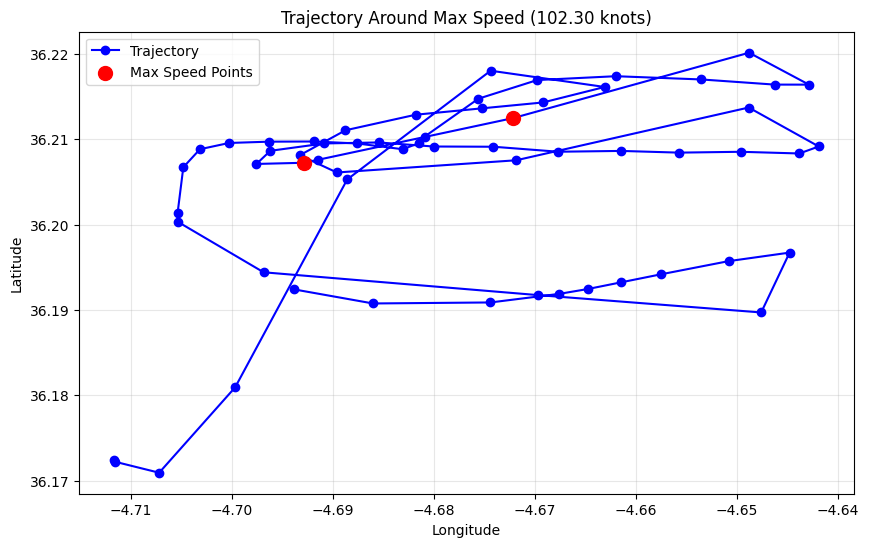

In [74]:
analyze_max_speed_context(noisy_voyage)

Looking at the dataframe we see the vessel is sailing at relatively low speeds (1-3 knots) and then suddenly jumps to 102,3 knots. This could be an indication of a noisy data transmission/reception. Looking at the pattern the vessel is sailing it could indicate that vessel is drifting/waiting to enter port etc.

We do the same procedure with MMSI 232036294, the highspeed craft.

In [75]:
speeds, subset_samples2, voyages2 = analyze_voyage_max_speeds(departures_ais, 232036294)

Max speeds for each voyage of MMSI 232036294:
---------------------------------------------
Voyage ID: d95f4be1-0f53-49dc-92e7-b8a6b570ff5d, max speed: 39.5 knots

Total samples (AIS data points) for MMSI 232036294: 14
Total unique voyages: 1


In [76]:
noisy_voyage2 = subset_samples2[subset_samples2.voyage_id=="d95f4be1-0f53-49dc-92e7-b8a6b570ff5d"] #Subset further for the voyage containing the high speed (change the voyage id)
noisy_voyage2 = noisy_voyage2.sort_values(by='pos_timestamp', inplace=False).reset_index(drop=False)
len(noisy_voyage2)

14

Above shows that the high-speed craft has one voyage with a speed exceeding 30 knots. In this voyage the max speed is 39.5 knots. It might seem high, but when googling the vessel and it shows it has a cruising speed and max speed of 40 and 42 knots respectively. The point here is to indicate that what constitutes a excessive/high speed depends on the vessel type and characteristics. 

Max speed context samples:


,index,voyage_id,voyage_status,mmsi,pos_timestamp,navigation_status,position_accuracy,longitude,latitude,course_over_ground,true_heading,timestamp_seconds,raim,rate_of_turn,speed_over_ground,pos_source,call_sign,name,ship_type,ref_point_a,ref_point_b,ref_point_c,ref_point_d,position_device,eta,draught,destination,meta_timestamp,imo,meta_source,flag,build_year,length,width,capacity_dwt,manager,owner,builder,class_society,capacity_gt,capacity_teu,capacity_liquid_gas,capacity_passenger,capacity_liquid_oil,commercial_size_class,vessel_type_details,draught_max,draught_min,capacity_nt,vid_prefix,month
0,2264849,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,PENDING_DEPARTURE,232036294,2024-07-21 16:59:37,UNDEFINED,False,-0.32863,39.45941,360.0,511,60,False,128.0,0.0,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
1,2261844,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,PENDING_DEPARTURE,232036294,2024-07-23 04:13:08,UNDEFINED,False,-0.32867,39.45941,360.0,511,60,False,128.0,0.0,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
2,2261845,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-23 04:23:06,UNDEFINED,False,-0.31495,39.46075,97.1,511,60,False,128.0,6.8,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
3,2261846,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-23 04:39:14,UNDEFINED,False,-0.19440,39.51024,61.9,511,60,False,128.0,38.8,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07
4,2265680,d95f4be1-0f53-49dc-92e7-b8a6b570ff5d,UNDER_WAY,232036294,2024-07-23 08:17:15,UNDEFINED,False,1.96110,41.14387,47.0,511,60,False,128.0,39.5,AISHUB,ZGQZ6,STEEL,37,6,10,2,2,GPS,NaT,0.0,,2023-09-20 04:40:45,0,SPIRE,GB,0,16.0,4.0,0,,,,,0,0,0,0,0,,,0.0,0.0,0,d9,2024-07


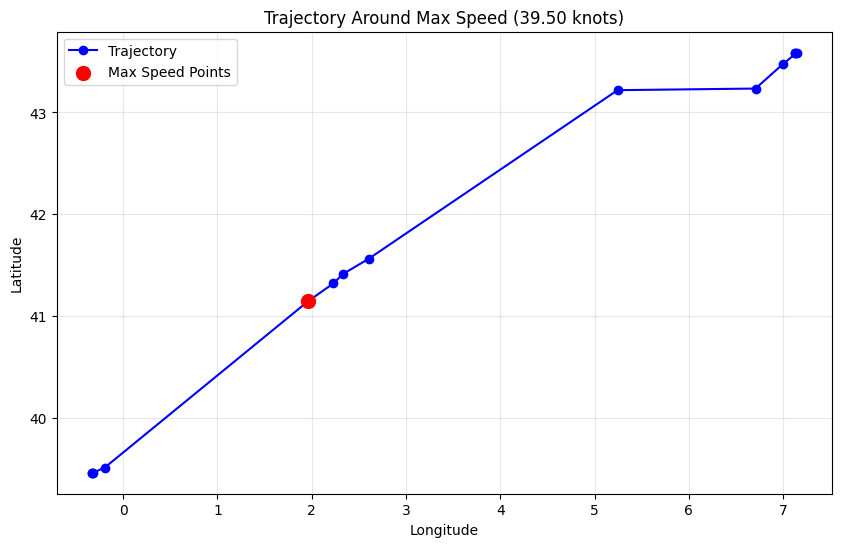

In [77]:
analyze_max_speed_context(noisy_voyage2)

Below plot shows the two vessels tracks in relation to land.

For the first one we can see it is inside the mediterrenean close the strait of Gibraltar.

For the second ship, the highspeed craft, we see it is sailing a route along the coast. (And across the coast at one point, which is likely due to data gaps and plotting a connecting line.)

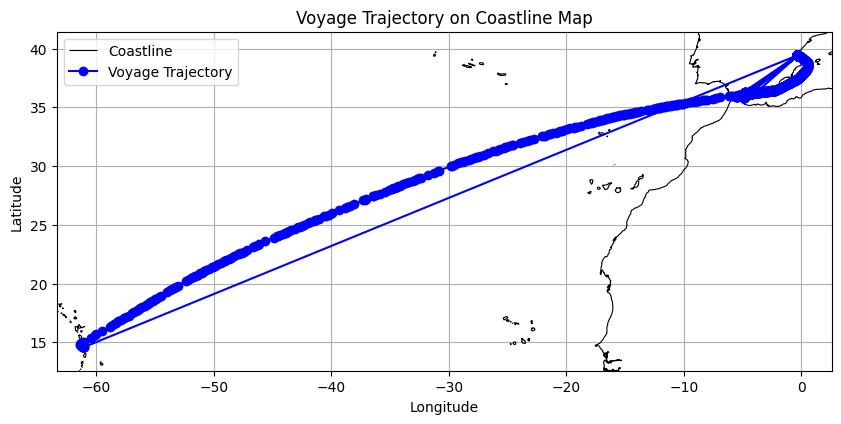

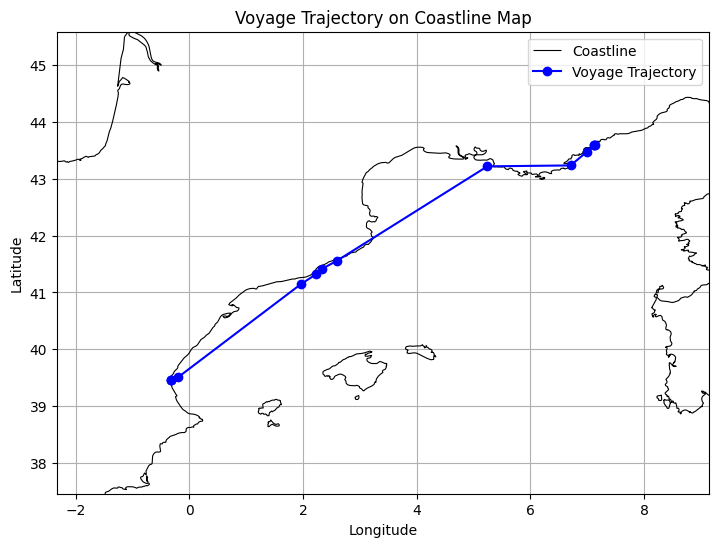

In [78]:
plot_voyage_on_coastline(voyage_data=subset_samples, coastline_data=coastline, padding=2)
plot_voyage_on_coastline(voyage_data=subset_samples2, coastline_data=coastline, padding=2)